# Download Dataset from Kaggle

In [1]:
from google.colab import files
files.upload()  # choose kaggle.json when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username": "josephmargoliss", "key": "KGAT_afc5ad64947f1c21daf285b3d55404d1"}\n'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install -q kaggle

In [4]:
# Step 4: Download the COVID-19 Image Dataset from Kaggle
!kaggle datasets download -d pranavraikokte/covid19-image-dataset

Dataset URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
License(s): CC-BY-SA-4.0
 94% 148M/158M [00:00<00:00, 1.54GB/s]
100% 158M/158M [00:00<00:00, 1.51GB/s]


In [5]:
# Step 5: Unzip the dataset into a "data" folder
!unzip -oq covid19-image-dataset.zip -d ./data

In [6]:
# Step 6: Check the extracted folder structure
import os

for root, dirs, files in os.walk('./data'):
    level = root.replace('./data', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:5]:  # show up to 5 files per folder
        print(f"{subindent}{f}")

data/
  Covid19-dataset/
    train/
      Normal/
        067.jpeg
        09.jpeg
        02.jpeg
        020.jpeg
        091.jpeg
      Viral Pneumonia/
        067.jpeg
        035.jpeg
        09.jpeg
        02.jpeg
        020.jpeg
      Covid/
        COVID-00001.jpg
        COVID-00013a.jpg
        076.jpg
        COVID-00015b.png
        02.jpeg
    test/
      Normal/
        0122.jpeg
        0119.jpeg
        0111.jpeg
        0105.jpeg
        0102.jpeg
      Viral Pneumonia/
        0119.jpeg
        0111.jpeg
        0105.jpeg
        0102.jpeg
        0115.jpeg
      Covid/
        COVID-00033.jpg
        COVID-00012.jpg
        0119.jpeg
        radiopaedia-2019-novel-coronavirus-infected-pneumonia.jpg
        auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg


# Dataset Cleaning/Preprocessing
- make clean copy of dataset
- remove non-image,zero-byte,corrupted files
- convert everything to RBG so the model gets consistent 3-channel images

In [7]:
import os, shutil
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

In [8]:
#create a clean copy of folder structure
raw_root = Path('data/Covid19-dataset')
clean_root = Path('data/Covid19-dataset-clean')

#remove old clean folder if we rerun
if clean_root.exists():
    shutil.rmtree(clean_root)

splits = ['train', 'test']
classes = ['Covid', 'Normal', 'Viral Pneumonia']

for split in splits:
    for cls in classes:
        (clean_root / split / cls).mkdir(parents=True, exist_ok=True)

print('Clean folder structure created at:', clean_root)

Clean folder structure created at: data/Covid19-dataset-clean


In [9]:
#copy only valid images
#skip files that are not .jpg/.jpeg/.png
#skip files that are corrupted or cant be open
#convert all images to rbg & save to clean folder

valid_exts = {'.jpg', '.jpeg', '.png'}
skipped_files = []

for split in splits:
  for cls in classes:
    src_dir = raw_root / split / cls
    dst_dir = clean_root / split / cls

    print(f'\nProcessing {src_dir} to {dst_dir}')

    for f in tqdm(list(src_dir.iterdir())):
      if not f.is_file():
        continue
      if f.suffix not in valid_exts:
        skipped_files.append(f, 'invalid extention')
        continue
      try:
        with Image.open(f) as img:
          img = img.convert('RGB')
          #keep same file name:
          img.save(dst_dir / f.name)
      except (UnidentifiedImageError, OSError) as e:
        skipped_files.append((f, f'corruptedL {e}'))


print('cleaning done')
print(f'Total skipped files: {len(skipped_files)}')
if skipped_files:
  print('Skipped files:')
  for f, reason in skipped_files[:20]:
    print('-', f, '->', reason)












Processing data/Covid19-dataset/train/Covid to data/Covid19-dataset-clean/train/Covid


100%|██████████| 111/111 [00:18<00:00,  5.88it/s]



Processing data/Covid19-dataset/train/Normal to data/Covid19-dataset-clean/train/Normal


100%|██████████| 70/70 [00:04<00:00, 14.56it/s]



Processing data/Covid19-dataset/train/Viral Pneumonia to data/Covid19-dataset-clean/train/Viral Pneumonia


100%|██████████| 70/70 [00:00<00:00, 71.65it/s]



Processing data/Covid19-dataset/test/Covid to data/Covid19-dataset-clean/test/Covid


100%|██████████| 26/26 [00:00<00:00, 57.53it/s]



Processing data/Covid19-dataset/test/Normal to data/Covid19-dataset-clean/test/Normal


100%|██████████| 20/20 [00:00<00:00, 26.20it/s]



Processing data/Covid19-dataset/test/Viral Pneumonia to data/Covid19-dataset-clean/test/Viral Pneumonia


100%|██████████| 20/20 [00:00<00:00, 74.09it/s]

cleaning done
Total skipped files: 0


In [10]:
#image count check
from collections import defaultdict

counts = defaultdict(int)

for split in splits:
  for cls in classes:
    counts[split, cls] = len(list((clean_root / split / cls).glob('*')))

for (split, cls), n in counts.items():
  print(f'{split:5} {cls:16} {n} images')




train Covid            111 images
train Normal           70 images
train Viral Pneumonia  70 images
test  Covid            26 images
test  Normal           20 images
test  Viral Pneumonia  20 images


# Save cleaned Dataset to GoogleDrive for Future Use

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!cp -r data/Covid19-dataset-clean/ '/content/drive/MyDrive/Deep Learning/DL Project/Covid19-dataset-clean'

In [13]:
#future cleaned data import line:

data_dir = '/content/drive/MyDrive/Deep Learning/DL Project/Covid19-dataset-clean'

# Data Preprocessing/Augmentation

In [14]:
import os
from pathlib import Path

data_root = Path(data_dir)

train_dir = os.path.join(data_root, 'train')
test_dir = os.path.join(data_root, 'test')
print(train_dir)
print(test_dir)

/content/drive/MyDrive/Deep Learning/DL Project/Covid19-dataset-clean/train
/content/drive/MyDrive/Deep Learning/DL Project/Covid19-dataset-clean/test


In [15]:
#build train/val/test datasets
#resize all images to same size
#create val aplit -20%- from the tr set
#use a batch size of 32

import tensorflow as tf
img_height = 224
img_width = 224
batchsize = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batchsize
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset='validation',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batchsize
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batchsize,
    shuffle=False #keep order for eval
)

class_names = train_ds.class_names
print('classes:', class_names)

Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.
Using 50 files for validation.
Found 66 files belonging to 3 classes.
classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [16]:
#normalize to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

def norm_map(x,y):
  return normalization_layer(x), y

train_ds = train_ds.map(norm_map)
val_ds = val_ds.map(norm_map)
test_ds = test_ds.map(norm_map)

In [17]:
#data augmentation for train set only
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

def aug_map(x,y):
  return data_augmentation(x), y

train_ds = train_ds.map(aug_map)

In [18]:
#prefetch for speed
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

### Class Imbalance?

In [19]:
import os
from collections import Counter

def count_images(folder):
  counts = {}
  for cls in os.listdir(folder):
    cls_path = os.path.join(folder, cls)
    if os.path.isdir(cls_path):
      counts[cls] = len(os.listdir(cls_path))
  return counts

print('train:', count_images(train_dir))
print('test:', count_images(test_dir))

train: {'Covid': 111, 'Normal': 70, 'Viral Pneumonia': 70}
test: {'Covid': 26, 'Normal': 20, 'Viral Pneumonia': 20}


Class imbalance not severe enough to apply any methods right now. Monitor precision/recall per class during eval to show if it struggles anywhere

# BASE CNN TRAINING

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
img_height = 224
img_width  = 224
num_classes = 3

def build_baseline_model(input_shape=(img_height, img_width, 3), num_classes=3):
    inputs = keras.Input(shape=input_shape)

    z = inputs #already normalized above

    # Block 1
    z = layers.Conv2D(32, (3,3), activation='relu', padding='same')(z)
    z = layers.MaxPooling2D()(z)

    # Block 2
    z = layers.Conv2D(64, (3,3), activation='relu', padding='same')(z)
    z = layers.MaxPooling2D()(z)

    # Block 3
    z = layers.Conv2D(128, (3,3), activation='relu', padding='same')(z)
    z = layers.MaxPooling2D()(z)

    # Dense head
    z = layers.Flatten()(z)
    z = layers.Dense(256, activation='relu')(z)
    z = layers.Dropout(0.5)(z)

    outputs = layers.Dense(num_classes, activation='softmax')(z)

    model = keras.Model(inputs=inputs, outputs=outputs, name="baseline_cnn")
    return model

In [22]:
baseline_model = build_baseline_model()
baseline_model.summary()

Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,387 (98.36 MB)

 Trainable params: 25,784,387 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
baseline_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy"
    ],
)

baseline_ckpt = "/content/drive/MyDrive/covid_baseline_best.keras"

callbacks_baseline = [
    keras.callbacks.ModelCheckpoint(
        baseline_ckpt,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

history_baseline = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks_baseline
)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.4779 - loss: 1.0716
Epoch 1: val_accuracy improved from -inf to 0.56000, saving model to /content/drive/MyDrive/covid_baseline_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.4809 - loss: 1.0676 - val_accuracy: 0.5600 - val_loss: 0.9160
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5245 - loss: 0.9573
Epoch 2: val_accuracy improved from 0.56000 to 0.74000, saving model to /content/drive/MyDrive/covid_baseline_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step - accuracy: 0.5279 - loss: 0.9515 - val_accuracy: 0.7400 - val_loss: 0.7272
Epoch 3/25
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6284 - loss: 0.7437
Epoch 3: val_accuracy improved from 0.74000 to 0.82000, saving model to /content/drive/MyDrive/covid_baseline_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 463ms/step - accuracy: 0.6392 - loss: 0.7350 - val_accuracy: 0.8200 - val_loss: 0.6453
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/ste

In [24]:
#baseline evaluation

test_loss, test_acc = baseline_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = baseline_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["Covid", "Normal", "Viral Pneumonia"]
))

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.8080 - loss: 0.3972
Test Loss: 0.45133882761001587
Test Accuracy: 0.7878788113594055
Confusion Matrix:
[[24  2  0]
 [ 0 11  9]
 [ 3  0 17]]

Classification Report:
                 precision    recall  f1-score   support

          Covid       0.89      0.92      0.91        26
         Normal       0.85      0.55      0.67        20
Viral Pneumonia       0.65      0.85      0.74        20

       accuracy                           0.79        66
      macro avg       0.80      0.77      0.77        66
   weighted avg       0.80      0.79      0.78        66



# Apply Transfer Learning


*   should improve performance
*   use EfficientNetB0
    - fast, common in medical imaging

In [25]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
#build transfer model

img_height = 224
img_width = 224
num_classes = 3

def build_transfer_model(input_shape=(img_height, img_width, 3), num_classes=3):
    inputs = keras.Input(shape=input_shape)

    # If your dataset is already normalized to [0,1], adjust:
    # EfficientNet expects 0–255 before preprocess_input
    x = inputs * 255.0
    x = preprocess_input(x)

    #load EfficientNetB0 backbone
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=x,
        pooling='avg'
    )

    #freeze the backbone
    base_model.trainable = False

    #add classifier head
    x = layers.Dense(256, activation="relu")(base_model.output)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="EfficientNetB0_transfer")
    return model


In [27]:

transfer_model = build_transfer_model()
transfer_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0_transfer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ multiply[0][0]    │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,378,278 (16.70 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [28]:
#compile model
transfer_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

#set up callbacks
transfer_ckpt = "/content/drive/MyDrive/covid_effnet_best.keras"

callbacks_transfer = [
    keras.callbacks.ModelCheckpoint(
        transfer_ckpt,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

#train!
history_transfer = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks_transfer
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3161 - loss: 1.2191
Epoch 1: val_accuracy improved from -inf to 0.36000, saving model to /content/drive/MyDrive/covid_effnet_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - accuracy: 0.3195 - loss: 1.2196 - val_accuracy: 0.3600 - val_loss: 1.0632
Epoch 2/15
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4369 - loss: 1.0880
Epoch 2: val_accuracy improved from 0.36000 to 0.66000, saving model to /content/drive/MyDrive/covid_effnet_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.4483 - loss: 1.0785 - val_accuracy: 0.6600 - val_loss: 0.9189
Epoch 3/15
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5587 - loss: 0.9302
Epoch 3: val_accuracy improved from 0.66000 to 0.76000, saving model to /content/drive/MyDrive/covid_effnet_best.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step - accuracy: 0.5546 - loss: 0.9380 - val_accuracy: 0.7600 - val_loss: 0.8147
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accur

In [29]:

#optionally increase performance w fine tuning
  # (I did this in my capstone and it really helped. - Hazel)

#unfreeze the entire EfficientNet backbone
# 1. Unfreeze the EfficientNet backbone
baseline_model.trainable = True

# 2. Optionally freeze the *lower* layers and fine-tune only the top
fine_tune_at = 100      # choose a split index
for i, layer in enumerate(baseline_model.layers):
    if i < fine_tune_at:
        layer.trainable = False

print("Total layers in base_model:", len(baseline_model.layers))
print("Trainable layers:", sum(l.trainable for l in baseline_model.layers))

# 3. Re-compile with a smaller learning rate
transfer_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),   # smaller LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# 4. Fine-tune
history_finetune = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks_transfer
)

Total layers in base_model: 11
Trainable layers: 0
Epoch 1/15
6/7 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9339 - loss: 0.3502
Epoch 1: val_accuracy did not improve from 0.94000
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.9268 - loss: 0.3521 - val_accuracy: 0.9400 - val_loss: 0.4012
Epoch 2/15
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8725 - loss: 0.3824
Epoch 2: val_accuracy did not improve from 0.94000
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.8721 - loss: 0.3852 - val_accuracy: 0.9400 - val_loss: 0.4000
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9229 - loss: 0.3341
Epoch 3: val_accuracy did not improve from 0.94000
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9226 - loss: 0.3379 - val_accuracy: 0.9400 - val_loss: 0.3989
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9127 - loss: 0.3650
Epoch 4: val_accuracy did not improve from 0.94000
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9112 - loss: 0.3667

In [30]:
import numpy as np
from sklearn.metrics import classification_report
#transer learning model evaluation
test_loss, test_acc = transfer_model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

def get_preds(model, dataset):
    y_true, y_pred = [], []
    for images, labels in dataset:
        probs = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(probs, axis=1))
    return np.array(y_true), np.array(y_pred)

# baseline
y_true_b, y_pred_b = get_preds(baseline_model, test_ds)
print("Baseline:\n", classification_report(
    y_true_b, y_pred_b,
    target_names=["Covid", "Normal", "Viral Pneumonia"]
))

# transfer
y_true_t, y_pred_t = get_preds(transfer_model, test_ds)
print("Transfer:\n", classification_report(
    y_true_t, y_pred_t,
    target_names=["Covid", "Normal", "Viral Pneumonia"]
))

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.8346 - loss: 0.3637
Test Accuracy: 0.8333333134651184
Baseline:
                  precision    recall  f1-score   support

          Covid       0.89      0.92      0.91        26
         Normal       0.85      0.55      0.67        20
Viral Pneumonia       0.65      0.85      0.74        20

       accuracy                           0.79        66
      macro avg       0.80      0.77      0.77        66
   weighted avg       0.80      0.79      0.78        66

Transfer:
                  precision    recall  f1-score   support

          Covid       1.00      0.96      0.98        26
         Normal       0.85      0.55      0.67        20
Viral Pneumonia       0.68      0.95      0.79        20

       accuracy                           0.83        66
      macro avg       0.84      0.82      0.81        66
   weighted avg       0.86      0.83      0.83        66



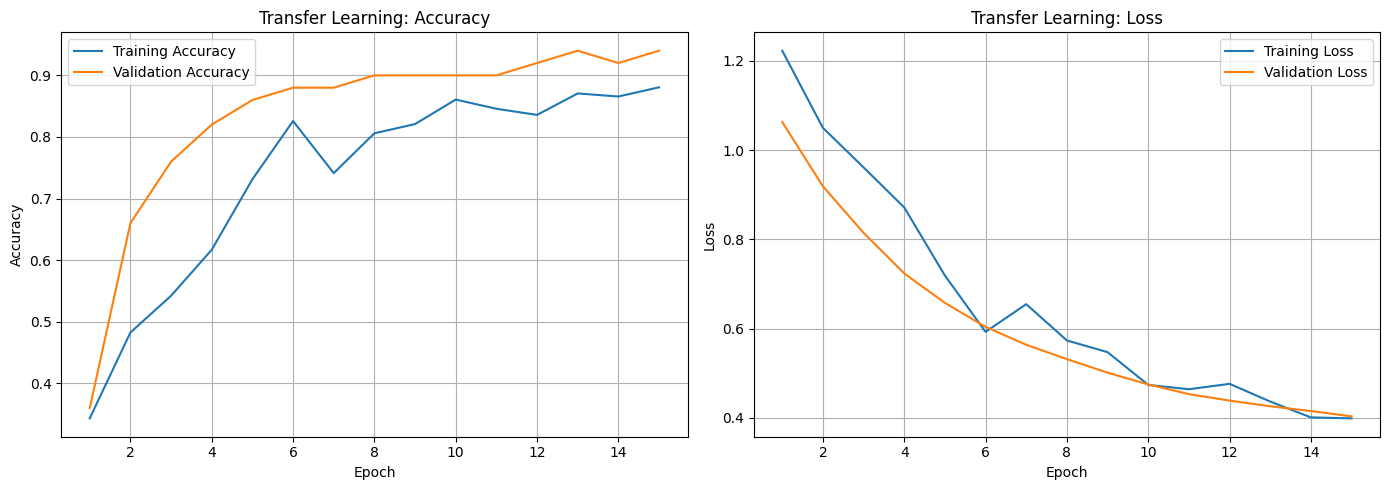

In [31]:
import matplotlib.pyplot as plt
#plot for paper of transfer learning val loss/val acc

# history_transfer = your model.fit(...) history object
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']
loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Transfer Learning: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Transfer Learning: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [32]:
#save model to drive
transfer_model.save('/content/drive/MyDrive/Deep Learning/covid_effnet_best.keras')

# Explainability

In [33]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# path you used when saving
model_path = "/content/drive/MyDrive/covid_effnet_best.keras"
transfer_model = keras.models.load_model(model_path)

class_names = ["Covid", "Normal", "Viral Pneumonia"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Grad CAM
Where the model is looking spatially

In [34]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2

class_names = ["Covid", "Normal", "Viral Pneumonia"]  # adjust if needed

In [35]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """
    img_array: shape (1, H, W, 3), values in [0,1]
    model: trained Keras model
    last_conv_layer_name: name of last conv layer (e.g. "block7a_project_conv")
    """
    # Model that maps input image to (conv layer outputs, predictions)
    grad_model = keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output],
    )

    # Forward + gradient pass
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    # Gradients of top predicted class w.r.t. conv outputs
    grads = tape.gradient(loss, conv_outputs)[0]          # (Hc, Wc, C)
    conv_outputs = conv_outputs[0]                        # (Hc, Wc, C)

    # Channel-wise mean of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Weight feature maps by importance
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    # ReLU + normalize to [0,1]
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap = heatmap / np.max(heatmap)

    return heatmap

In [36]:
def overlay_heatmap(heatmap, image, alpha=0.4):
    """
    heatmap: 2D array (Hc, Wc) in [0,1]
    image:  3D array (H, W, 3) in [0,1]
    """
    h, w = image.shape[:2]

    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (w, h))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Convert original image to uint8
    img_uint8 = np.uint8(image * 255.0)

    # Blend: mostly X-ray with some heatmap
    overlay = cv2.addWeighted(img_uint8, 0.7, heatmap_color, 0.3, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    return overlay_rgb


In [37]:
def plot_gradcam_batch(model, dataset, n_images=3,
                       last_conv_layer_name="block7a_project_conv"):
    # grab one batch from dataset
    for images, labels in dataset.take(1):
        images_batch = images.numpy()   # (B, H, W, 3), [0,1]
        labels_batch = labels.numpy()
        break

    n_images = min(n_images, images_batch.shape[0])

    plt.figure(figsize=(16, 4 * n_images))

    for idx in range(n_images):
        img = images_batch[idx]
        label = labels_batch[idx]

        img_input = np.expand_dims(img, axis=0)  # (1, H, W, 3)

        # predictions
        preds = model.predict(img_input, verbose=0)[0]
        pred_class = np.argmax(preds)
        pred_name = class_names[pred_class]
        true_name = class_names[label]

        # Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(
            img_input, model, last_conv_layer_name
        )
        overlay = overlay_heatmap(heatmap, img)

        row = idx * 4

        # 1. Original
        plt.subplot(n_images, 4, row + 1)
        plt.imshow(img)
        plt.title(f"Original\nTrue: {true_name}")
        plt.axis("off")

        # 2. Heatmap only
        plt.subplot(n_images, 4, row + 2)
        plt.imshow(heatmap, cmap="jet", vmin=0, vmax=1)
        plt.title("Grad-CAM Heatmap")
        plt.axis("off")

        # 3. Overlay
        plt.subplot(n_images, 4, row + 3)
        plt.imshow(overlay)
        plt.title("Overlay")
        plt.axis("off")

        # 4. Class probabilities
        plt.subplot(n_images, 4, row + 4)
        plt.bar(range(len(class_names)), preds)
        plt.xticks(range(len(class_names)), class_names, rotation=30)
        plt.ylim(0, 1)
        plt.title(f"Pred: {pred_name}\nTrue: {true_name}")
        plt.grid(True, axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_2']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_2']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_2']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


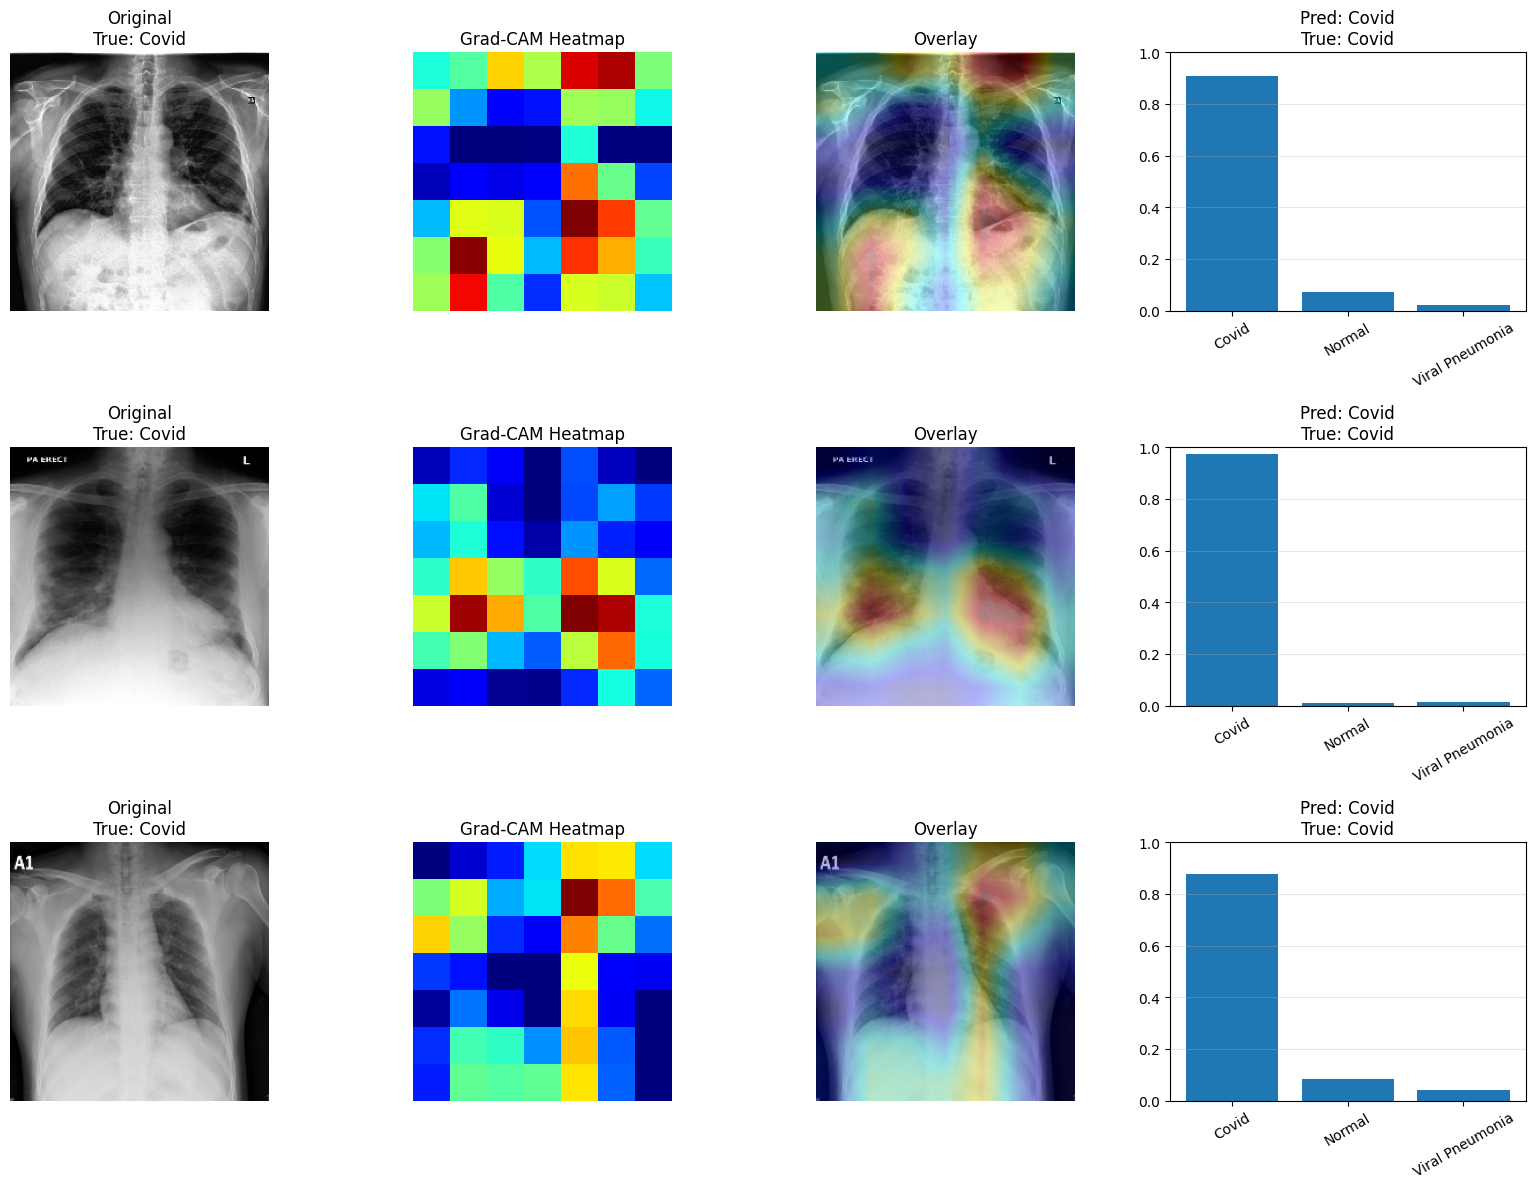

In [38]:
plot_gradcam_batch(transfer_model, test_ds, n_images=3,
                   last_conv_layer_name="block7a_project_conv")

## Gradient Based Saliency Maps
which pixels most affect the prediction

In [39]:
# grab one batch from test_ds
for images_batch, labels_batch in test_ds.take(1):
    images_batch = images_batch.numpy()   # (B, H, W, 3), in [0,1]
    labels_batch = labels_batch.numpy()
    break

In [40]:
def compute_saliency_map(model, image):
    """
    image: (H, W, 3), values in [0,1]
    returns: saliency map (H, W)
    """
    img = np.expand_dims(image, axis=0)  # (1, H, W, 3)

    img_tensor = tf.convert_to_tensor(img)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor, training=False)
        top_class = tf.argmax(preds[0])
        top_score = preds[0, top_class]

    grads = tape.gradient(top_score, img_tensor)[0]  # (H, W, 3)

    # take max abs gradient over channels
    saliency = tf.reduce_max(tf.abs(grads), axis=-1).numpy()

    # normalize to [0,1]
    if saliency.max() > 0:
        saliency = saliency / saliency.max()

    return saliency

In [41]:
import cv2
import numpy as np

def compute_saliency_map_smooth(model, image, blur_ksize=9):
    saliency = compute_saliency_map(model, image)  # your existing function
    # smooth the saliency map to highlight regions instead of pixels
    saliency_blurred = cv2.GaussianBlur(saliency, (blur_ksize, blur_ksize), 0)
    # re-normalize
    if saliency_blurred.max() > 0:
        saliency_blurred = saliency_blurred / saliency_blurred.max()
    return saliency_blurred

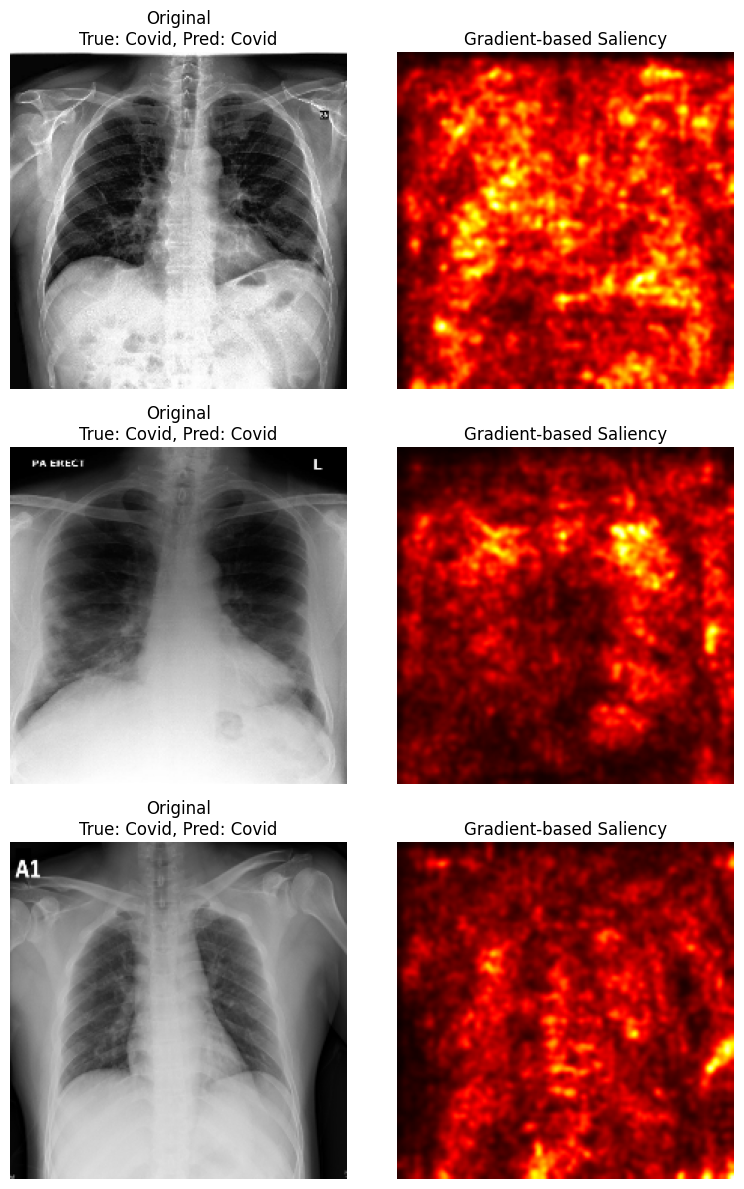

In [42]:
def plot_saliency_batch(model, images, labels, n_images=3):
    n_images = min(n_images, images.shape[0])
    plt.figure(figsize=(8, 4 * n_images))

    for i in range(n_images):
        img = images[i]
        label = labels[i]
        saliency = compute_saliency_map_smooth(transfer_model, img)

        # prediction
        preds = model.predict(np.expand_dims(img, 0), verbose=0)[0]
        pred_class = np.argmax(preds)

        # original
        plt.subplot(n_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.title(f"Original\nTrue: {class_names[label]}, Pred: {class_names[pred_class]}")
        plt.axis("off")

        # saliency
        plt.subplot(n_images, 2, 2*i + 2)
        plt.imshow(saliency, cmap="hot")
        plt.title("Gradient-based Saliency")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_saliency_batch(transfer_model, images_batch, labels_batch, n_images=3)

## Occlusion Saliency Maps
how pred changes when diff regions are removed

In [43]:
def compute_occlusion_heatmap(model, image, target_class=None,
                              patch_size=32, stride=16, mask_value=0.0):
    """
    image: (H, W, 3) in [0,1]
    returns: occlusion heatmap (H, W)
    """
    H, W, C = image.shape
    img = np.expand_dims(image, 0)

    # choose class: top predicted class if None
    base_preds = model.predict(img, verbose=0)[0]
    if target_class is None:
        target_class = np.argmax(base_preds)
    base_score = base_preds[target_class]

    heatmap = np.zeros((H, W), dtype=np.float32)

    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            occluded = img.copy()
            occluded[0, y:y+patch_size, x:x+patch_size, :] = mask_value

            preds = model.predict(occluded, verbose=0)[0]
            score = preds[target_class]

            # drop in score → importance
            delta = base_score - score
            heatmap[y:y+patch_size, x:x+patch_size] += delta

    # normalize to [0,1]
    max_val = heatmap.max()
    if max_val > 0:
        heatmap /= max_val

    return heatmap, target_class

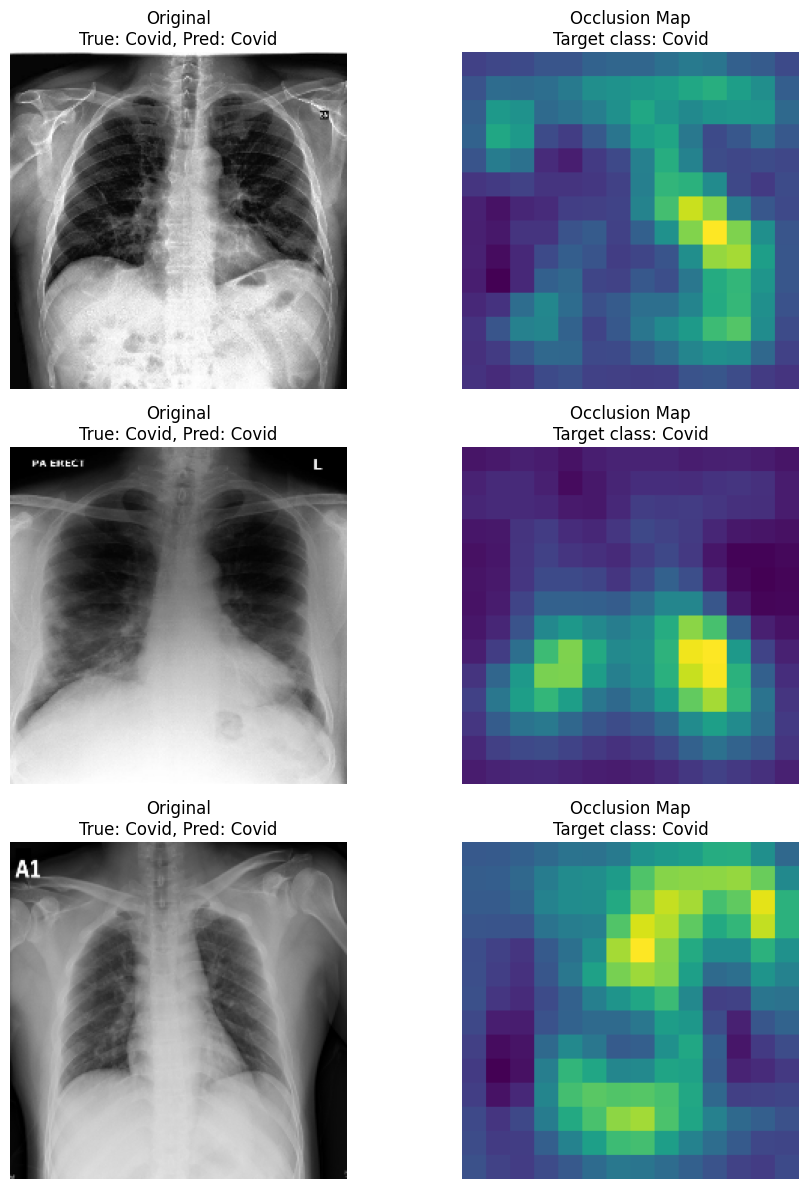

In [44]:
def plot_occlusion_batch(model, images, labels, n_images=3,
                         patch_size=32, stride=16):
    n_images = min(n_images, images.shape[0])
    plt.figure(figsize=(10, 4 * n_images))

    for i in range(n_images):
        img = images[i]
        label = labels[i]

        heatmap, target_class = compute_occlusion_heatmap(
            model, img, target_class=None,
            patch_size=patch_size, stride=stride
        )

        preds = model.predict(np.expand_dims(img, 0), verbose=0)[0]
        pred_class = np.argmax(preds)

        row = 2*i

        # original
        plt.subplot(n_images, 2, row + 1)
        plt.imshow(img)
        plt.title(f"Original\nTrue: {class_names[label]}, Pred: {class_names[pred_class]}")
        plt.axis("off")

        # occlusion heatmap
        plt.subplot(n_images, 2, row + 2)
        plt.imshow(heatmap, cmap="viridis")
        plt.title(f"Occlusion Map\nTarget class: {class_names[target_class]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_occlusion_batch(transfer_model, images_batch, labels_batch, n_images=3)

## Applying Transformers

### Hybrid Model (CNN Backbone + Transfer Learning + Transformer Head)

In [45]:
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention,
    GlobalAveragePooling1D, Input, Reshape, Add, Layer
)
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [46]:

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training = None):
        attn_output = self.att(inputs, inputs, training =training)
        attn_output = self.dropout1(attn_output, training =training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1, training =training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [47]:
def cnn_tran_pipe(input_shape=(224, 224, 3), num_classes=3, embed_dim=128, num_heads=4, ff_dim=256, transformer_blocks=1,freeze_backbone=True):
    inputs = Input(shape=input_shape)

    x = inputs * 255.0
    x = preprocess_input(x)

    #cnn
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=x,
        pooling=None
    )

    #freeze for first pass
    base_model.trainable = not freeze_backbone
    x = base_model.output
    x = Reshape((49, 1280))(x)
    x = Dense(embed_dim)(x)

    # encoder
    for _ in range(transformer_blocks):
        x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)

    # pooling
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.35)(x)

    #classify
    outputs = Dense(num_classes, activation="softmax",
                    kernel_regularizer=regularizers.l2(1e-5))(x)

    model = tf.keras.Model(inputs, outputs, name="cnn_tran")

    return model, base_model

cnn_tran, effnet = cnn_tran_pipe()
cnn_tran.summary()

Model: "cnn_tran"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Multiply)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ multiply_1[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_3[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_4[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,544,166 (17.33 MB)

 Trainable params: 494,595 (1.89 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [48]:
class LinearWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, warmup_steps, warmup_lr=0.0):
        super().__init__()
        self.base_lr = base_lr
        self.warmup_steps = warmup_steps
        self.warmup_lr = warmup_lr

    def __call__(self, step):
        warmup_lr = self.warmup_lr + (self.base_lr - self.warmup_lr) * tf.cast(step, tf.float32) / tf.cast(self.warmup_steps, tf.float32)
        return tf.where(step < self.warmup_steps, warmup_lr, self.base_lr)

#set lr warmup parameters
train_steps = tf.data.experimental.cardinality(train_ds).numpy()
epochs = 40
total_steps = train_steps * epochs
warmup_steps = total_steps // 10

lr_schedule = LinearWarmup(base_lr=1e-4, warmup_steps=warmup_steps)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

cnn_tran.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_tran = cnn_tran.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop]
)


Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.1509 - loss: 1.6458 - val_accuracy: 0.1600 - val_loss: 1.4014
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.1477 - loss: 1.5558 - val_accuracy: 0.2200 - val_loss: 1.2375
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.3273 - loss: 1.3435 - val_accuracy: 0.4400 - val_loss: 1.0250
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.4872 - loss: 1.0862 - val_accuracy: 0.6600 - val_loss: 0.7991
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.5865 - loss: 0.9194 - val_accuracy: 0.7200 - val_loss: 0.6478
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.6405 - loss: 0.7535 - val_accuracy: 0.7600 - val_loss: 0.5655
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.7696 - loss: 0.5870 - val_accuracy: 0.8400 - val_loss: 0.4990
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.8289 - loss: 0.5030 - val_accuracy: 0.8600 - val_loss: 0

In [50]:
#test
test_loss, test_acc = cnn_tran.evaluate(test_ds)
print(f"Test Acc: {test_acc:.4f}")


y_true_b, y_pred_b = get_preds(cnn_tran, test_ds)
print("Hybrid:\n", classification_report(
    y_true_b, y_pred_b,
    target_names=["Covid", "Normal", "Viral Pneumonia"]
))


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8999 - loss: 0.2063
Test Acc: 0.9091
Hybrid:
                  precision    recall  f1-score   support

          Covid       1.00      0.96      0.98        26
         Normal       0.94      0.75      0.83        20
Viral Pneumonia       0.80      1.00      0.89        20

       accuracy                           0.91        66
      macro avg       0.91      0.90      0.90        66
   weighted avg       0.92      0.91      0.91        66



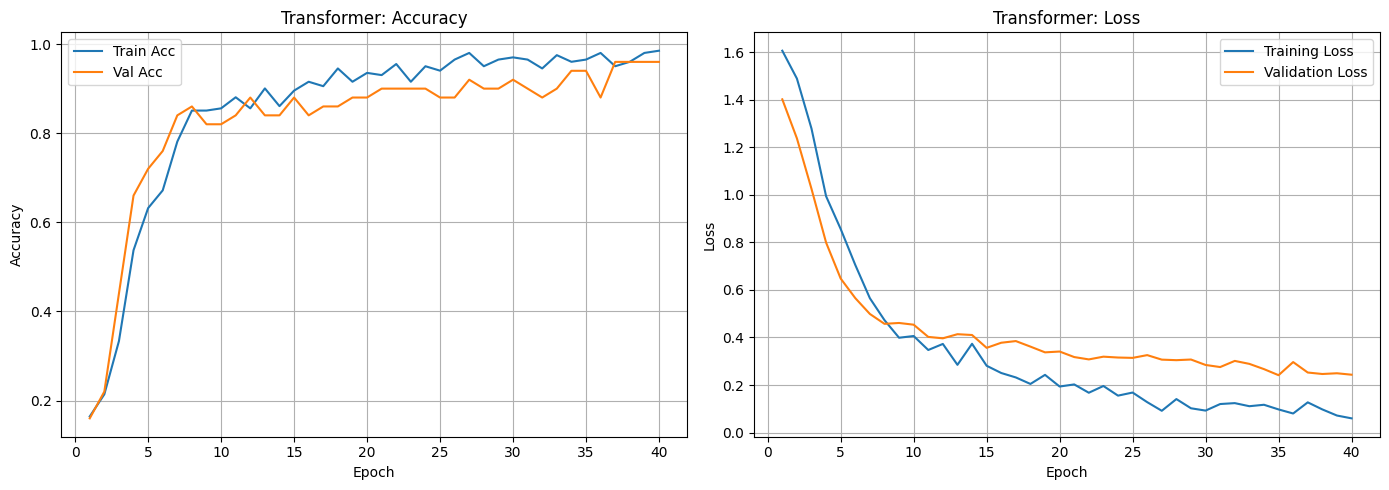

In [51]:


acc = history_tran.history['accuracy']
val_acc = history_tran.history['val_accuracy']
loss = history_tran.history['loss']
val_loss = history_tran.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

#accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.title('Transformer: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Transformer: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [52]:
# Fine tuning at lower learning rate and unfreezing top layers of eff net

fine_tune_at = 100

for layer in effnet.layers[:fine_tune_at]:
    layer.trainable = False

for layer in effnet.layers[fine_tune_at:]:
    layer.trainable = True


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

cnn_tran.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_tran = cnn_tran.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop]
)

#test
test_loss, test_acc = cnn_tran.evaluate(test_ds)
print(f"\nTest Acc: {test_acc:.4f}")


y_true_b, y_pred_b = get_preds(cnn_tran, test_ds)
print("Hybrid :\n", classification_report(
    y_true_b, y_pred_b,
    target_names=["Covid", "Normal", "Viral Pneumonia"]
))

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.6484 - loss: 0.8717 - val_accuracy: 0.9600 - val_loss: 0.2263
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.6055 - loss: 0.9288 - val_accuracy: 0.9400 - val_loss: 0.2159
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.6200 - loss: 0.8431 - val_accuracy: 0.9600 - val_loss: 0.2117
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.6124 - loss: 0.8685 - val_accuracy: 0.9600 - val_loss: 0.2125
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.6123 - loss: 0.8743 - val_accuracy: 0.9600 - val_loss: 0.2166
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.6797 - loss: 0.7083 - val_accuracy: 0.9600 - val_loss: 0.2244
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.6451 - loss: 0.8959 - val_accuracy: 0.9600 - val_loss: 0.2355
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.7117 - loss: 0.7062 - val_accuracy: 0.9400 - val_loss: 

Hybrid :
                  precision    recall  f1-score   support

          Covid       1.00      0.96      0.98        26
         Normal       0.94      0.75      0.83        20
Viral Pneumonia       0.80      1.00      0.89        20

       accuracy                           0.91        66
      macro avg       0.91      0.90      0.90        66
   weighted avg       0.92      0.91      0.91        66



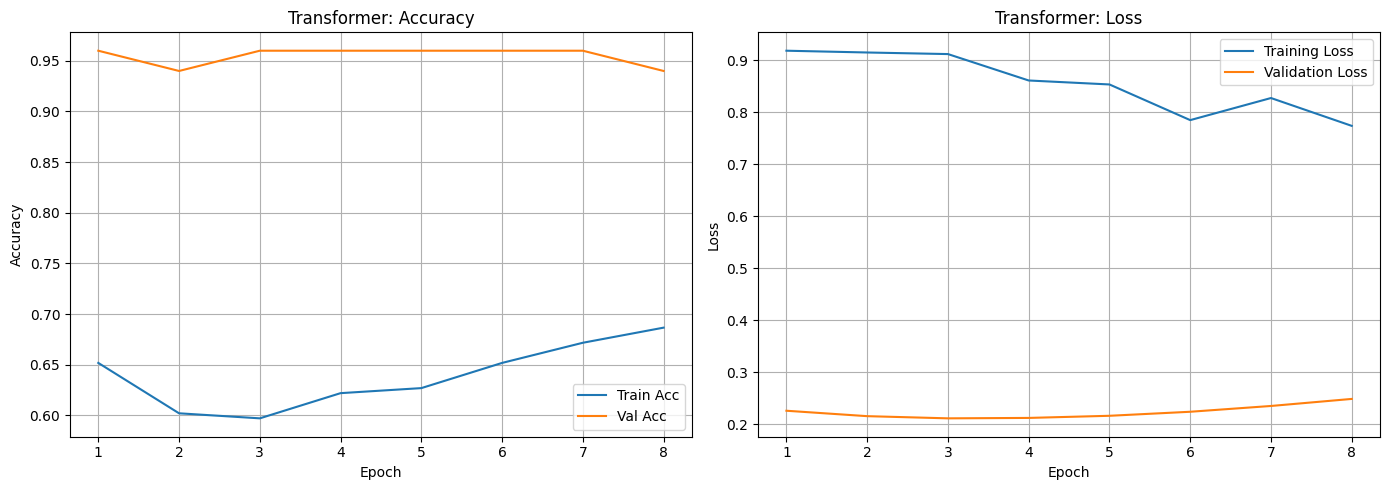

In [53]:
acc = history_tran.history['accuracy']
val_acc = history_tran.history['val_accuracy']
loss = history_tran.history['loss']
val_loss = history_tran.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

#accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.title('Transformer: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Transformer: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Results and Figures



3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step


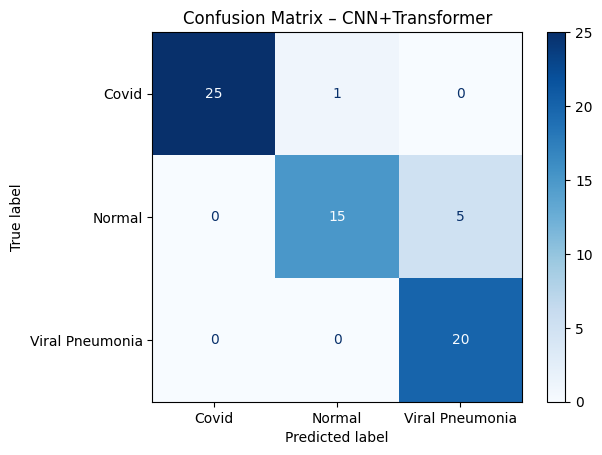

In [54]:


# predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = cnn_tran.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)


# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – CNN+Transformer")
plt.show()


In [55]:
### Taken Mapping

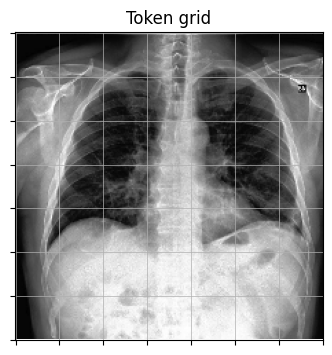

In [56]:

# get last cnn feature map
feature_extractor = tf.keras.Model(
    inputs=cnn_tran.input,
    outputs=cnn_tran.get_layer("top_activation").output
)

# one example
for batch_imgs, batch_labels in test_ds.take(1):
    img = batch_imgs[0].numpy()
    label = batch_labels[0].numpy()
    break

feature_map = feature_extractor(img[None, ...])
Hf, Wf = feature_map.shape[1], feature_map.shape[2]

# overlay
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img)
ax.set_xticks(np.linspace(0, img.shape[1], Wf + 1))
ax.set_yticks(np.linspace(0, img.shape[0], Hf + 1))
ax.grid(which='both', linestyle='-', linewidth=0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title(f"Token grid")
plt.show()


In [57]:
# Find layers

def tran_layers(model):
    transformer_layer = None
    gap_layer = None
    drop_layer = None
    fc_layer = None

    for layer in model.layers:
        # transformer encoder
        if "TransformerEncoder" in layer.__class__.__name__:
            transformer_layer = layer

        # global avg pooling
        if isinstance(layer, tf.keras.layers.GlobalAveragePooling1D):
            gap_layer = layer

        # dropout
        if isinstance(layer, tf.keras.layers.Dropout):
            drop_layer = layer

        # dense
        if (
            isinstance(layer, tf.keras.layers.Dense)
            and layer.units == 3
        ):
            fc_layer = layer

    return transformer_layer, gap_layer, drop_layer, fc_layer

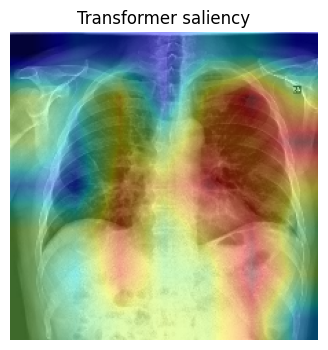

In [58]:
transformer_layer, gap_layer, drop_layer, fc_layer = tran_layers(cnn_tran)


token_model = tf.keras.Model(
    inputs=cnn_tran.input,
    outputs=transformer_layer.output
)

def token_heatmap(single_img):

    x = single_img[None, ...].astype("float32")

    with tf.GradientTape() as tape:
        tokens = token_model(x)
        tape.watch(tokens)
        pooled  = gap_layer(tokens)
        dropped = drop_layer(pooled, training=False)
        logits  = fc_layer(dropped)
        pred_class = tf.argmax(logits[0])
        class_score = logits[0, pred_class]

    grads = tape.gradient(class_score, tokens)[0].numpy()
    tokens_val = tokens[0].numpy()

    token_importance = np.mean(np.abs(grads * tokens_val), axis=-1)

    # normalize
    token_importance -= token_importance.min()
    token_importance /= (token_importance.max() + 1e-8)

    heatmap = token_importance.reshape(7, 7)
    return heatmap

def overlay(img, heatmap):

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.imshow(heatmap_resized, cmap="jet", alpha=0.4)
    plt.axis("off")
    plt.title("Transformer saliency")
    plt.show()

heatmap = token_heatmap(img)
overlay(img, heatmap)


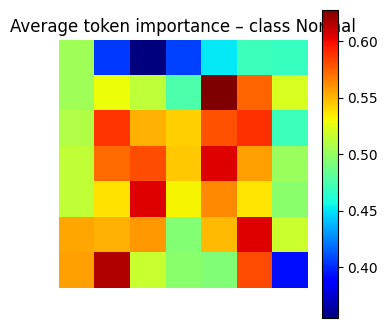

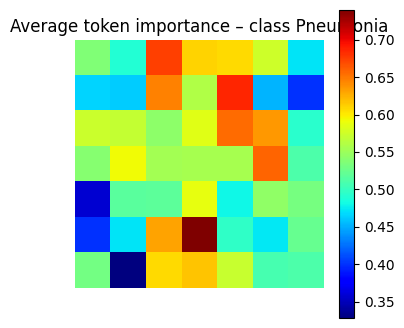

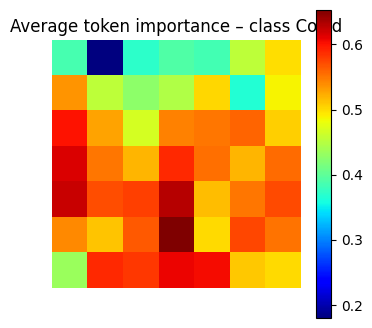

In [59]:
# token importance Extraction

def class_importance(single_img, class_idx):

    x = single_img[None, ...].astype("float32")

    with tf.GradientTape() as tape:
        tokens = token_model(x)
        tape.watch(tokens)
        pooled  = gap_layer(tokens)
        dropped = drop_layer(pooled, training=False)
        logits  = fc_layer(dropped)
        class_score = logits[0, class_idx]

    grads = tape.gradient(class_score, tokens)[0].numpy()
    tokens_val = tokens[0].numpy()


    token_importance = np.mean(np.abs(grads * tokens_val), axis=-1)

    #normalize
    token_importance -= token_importance.min()
    token_importance /= (token_importance.max() + 1e-8)

    return token_importance

def class_importance_agg(dataset, class_idx, max_images=100, use_true_labels=True):

    sum_imp = np.zeros(49, dtype=np.float32)
    count = 0

    for batch_imgs, batch_labels in dataset:
        batch_imgs_np = batch_imgs.numpy()
        batch_labels_np = batch_labels.numpy()

        for i in range(batch_imgs_np.shape[0]):
            img_i = batch_imgs_np[i]
            label_i = batch_labels_np[i]
            if use_true_labels:
                if label_i != class_idx:
                    continue
            else:
                pred = np.argmax(cnn_tran(img_i[None, ...]).numpy()[0])
                if pred != class_idx:
                    continue
            imp = class_importance(img_i, class_idx)
            sum_imp += imp
            count += 1
            if count >= max_images:
                break
        if count >= max_images:
            break

    avg_imp = sum_imp / count
    heatmap = avg_imp.reshape(7, 7)
    return heatmap

class_names = ["Normal", "Pneumonia", "Covid"]

for c in range(3):
    heatmap_c = class_importance_agg(test_ds, class_idx=c, max_images=200)
    plt.figure(figsize=(4,4))
    plt.imshow(heatmap_c, cmap="jet")
    plt.colorbar()
    plt.title(f"Average token importance – class {class_names[c]}")
    plt.axis("off")
    plt.show()

In [60]:
# combine into one visual for each class

class_names = ["Covid", "Normal", "Viral Pneumonia"]

def pic_per_class(dataset, num_classes=3):
    pics = [None] * num_classes
    for batch_imgs, batch_labels in dataset:
        imgs = batch_imgs.numpy()
        labels = batch_labels.numpy()
        for img, lab in zip(imgs, labels):
            lab = int(lab)
            if 0 <= lab < num_classes and pics[lab] is None:
                pics[lab] = (img, lab)
        if all(e is not None for e in pics):
            break
    return pics

images = pic_per_class(test_ds, num_classes=3)

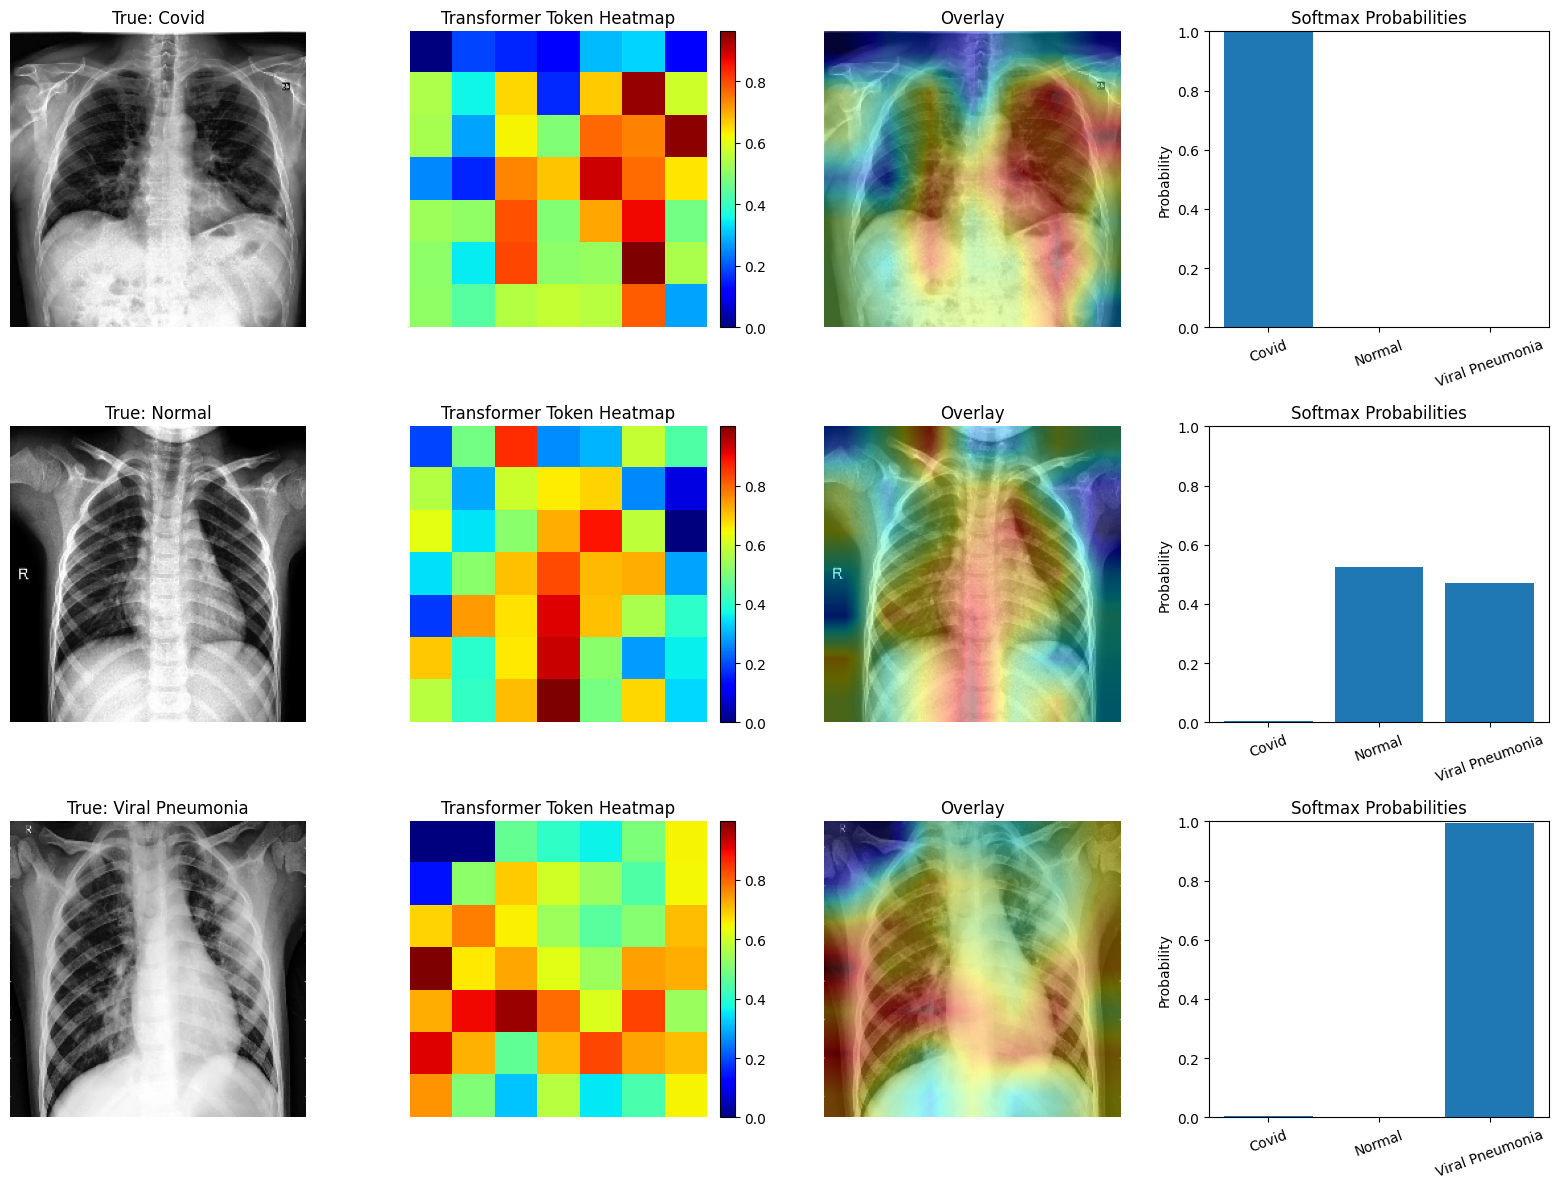

In [61]:



fig, axes = plt.subplots(3, 4, figsize=(16, 12))

if num_classes == 1:
    axes = np.expand_dims(axes, 0)

for row, (img, true_label) in enumerate(images):
    img = img.astype("float32")
    probs = cnn_tran(img[None, ...]).numpy()[0]
    pred_label = np.argmax(probs)

    ax = axes[row, 0]
    ax.imshow(img)
    ax.set_xticks(np.linspace(0, img.shape[1], Wf + 1))
    ax.set_yticks(np.linspace(0, img.shape[0], Hf + 1))
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(f"True: {class_names[true_label]}")
    ax.axis("off")

    heatmap = token_heatmap(img)
    ax = axes[row, 1]
    im = ax.imshow(heatmap, cmap="jet")
    ax.set_title("Transformer Token Heatmap")
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax = axes[row, 2]
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    ax.imshow(img)
    ax.imshow(heatmap_resized, cmap="jet", alpha=0.4)
    ax.axis("off")
    ax.set_title("Overlay")

    ax = axes[row, 3]
    ax.bar(class_names, probs)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Probability")
    ax.set_title(f"Softmax Probabilities")
    ax.tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()
